<u><b><b>**UCI BIKE SHARING DATA SET (Decession Tree Regression)</b></b></u>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pydotplus

from sklearn import tree
from sklearn import metrics
from sklearn import preprocessing
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

# Setting the parameters for the seaborn library
sn.set_style('whitegrid')
sn.set_context('talk')
params = {'legend.fontsize' : 'x-large',
           'figure.figsize' : (30, 10),
             'axes.labelsize' : 'x-large',
             'axes.titlesize' : 'x-large',
             'xtick.labelsize' : 'x-large',
             'ytick.labelsize' : 'x-large'}

plt.rcParams.update(params)

Preprocessing/ EDA (Explotary Data Analysis)

In [2]:
# Loading the data

hour_df = pd.read_csv('hour.csv')
print("shape of dataset is :", hour_df.shape)
hour_df.head()

shape of dataset is : (17379, 17)


instant      dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1   0        0        6           0   
1        2  2011-01-01       1   0     1   1        0        6           0   
2        3  2011-01-01       1   0     1   2        0        6           0   
3        4  2011-01-01       1   0     1   3        0        6           0   
4        5  2011-01-01       1   0     1   4        0        6           0   

   weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  
0           1  0.24  0.2879  0.81        0.0       3          13   16  
1           1  0.22  0.2727  0.80        0.0       8          32   40  
2           1  0.22  0.2727  0.80        0.0       5          27   32  
3           1  0.24  0.2879  0.75        0.0       3          10   13  
4           1  0.24  0.2879  0.75        0.0       0           1    1

In [3]:
hour_df.dtypes

instant         int64
dteday         object
season          int64
yr              int64
mnth            int64
hr              int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
dtype: object

As mentioned in the documentation for the dataset, there are bike sharing as well as weather attributes available. The attribute dteday would require type conversion from object (or string type) to timestamp. Attributes like season, holiday, weekday, and so on are inferred as integers by pandas, and they would require conversion to categoricals for proper understanding.

In [4]:
hour_df.rename(columns={'instant':'rec_id',
                        'dteday':'datetime',
                        'holiday':'is_holiday',
                        'workingday':'is_workingday',
                        'weathersit':'weather_condition',
                        'hum':'humidity',
                        'mnth':'month',
                        'cnt':'total_count',
                        'hr':'hour',
                        'yr':'year'},inplace=True)

Now that we have attribute names cleaned up, we perform type-casting of attributes using utilities like pd.to_datetime() and astype(). The following snippet gets the attributes into proper data types .

In [5]:
# Date and time conversion
hour_df['datetime'] = pd.to_datetime(hour_df.datetime)

# Categorigical Variables
# Categoricals are a pandas data type corresponding to categorical variables in statistics. A categorical variable takes on a limited, and usually fixed, number of possible values ( categories ; levels in R).
hour_df['season'] = hour_df.season.astype('category')
hour_df['is_holiday'] = hour_df.is_holiday.astype('category')
hour_df['weekday'] = hour_df.weekday.astype('category')
hour_df['weather_condition'] = hour_df.weather_condition.astype('category')
hour_df['is_workingday'] = hour_df.is_workingday.astype('category')
hour_df['month'] = hour_df.month.astype('category')
hour_df['year'] = hour_df.year.astype('category')
hour_df['hour'] = hour_df.hour.astype('category')


Distribution And Trends

[Text(0.5, 1.0, 'Season wise hourly distribution of counts')]

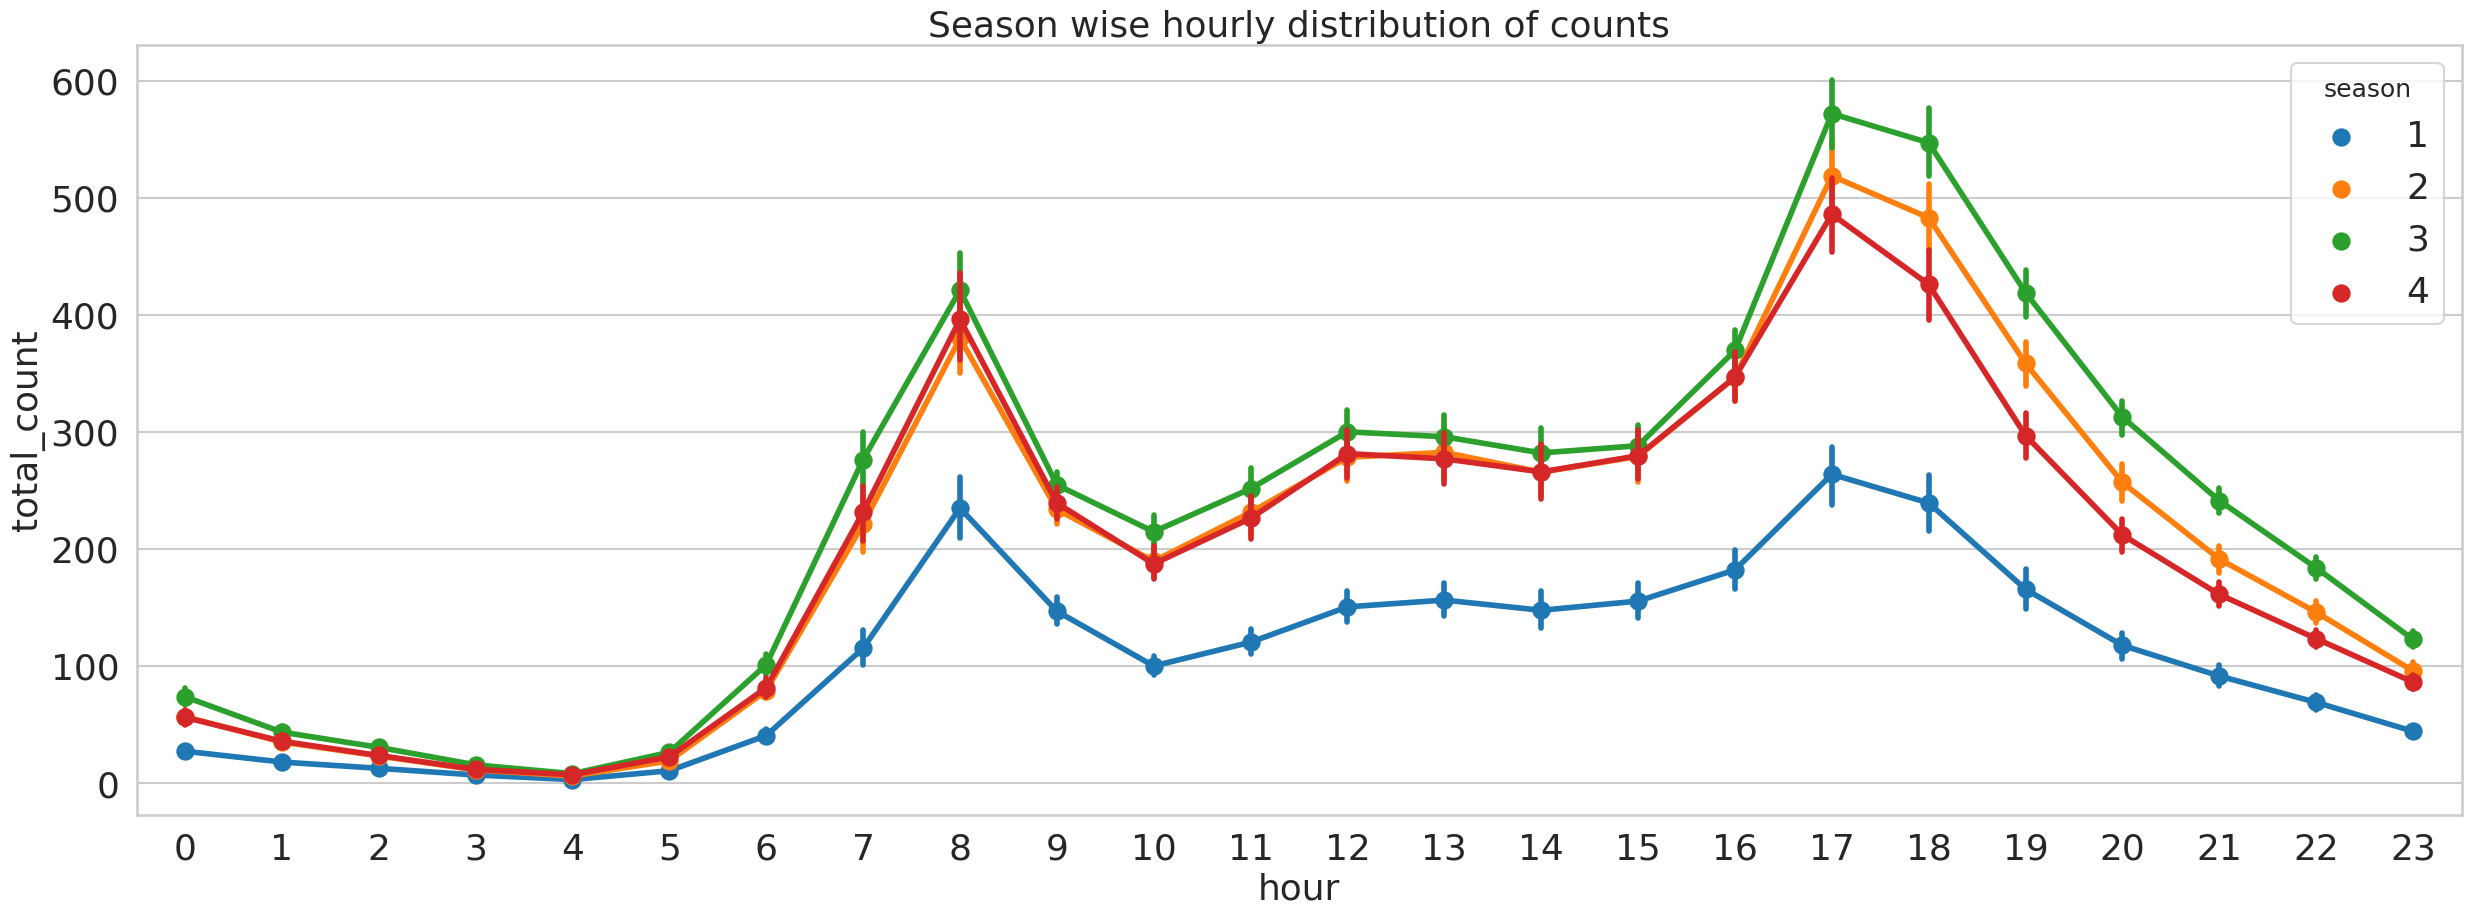

In [6]:
fig, ax = plt.subplots()
sn.pointplot(data = hour_df[['hour', 'total_count', 'season']], x='hour', y='total_count', hue='season', ax=ax)
ax.set(title="Season wise hourly distribution of counts")

[Text(0.5, 1.0, 'Weekdays wise hourly distribution of counts')]

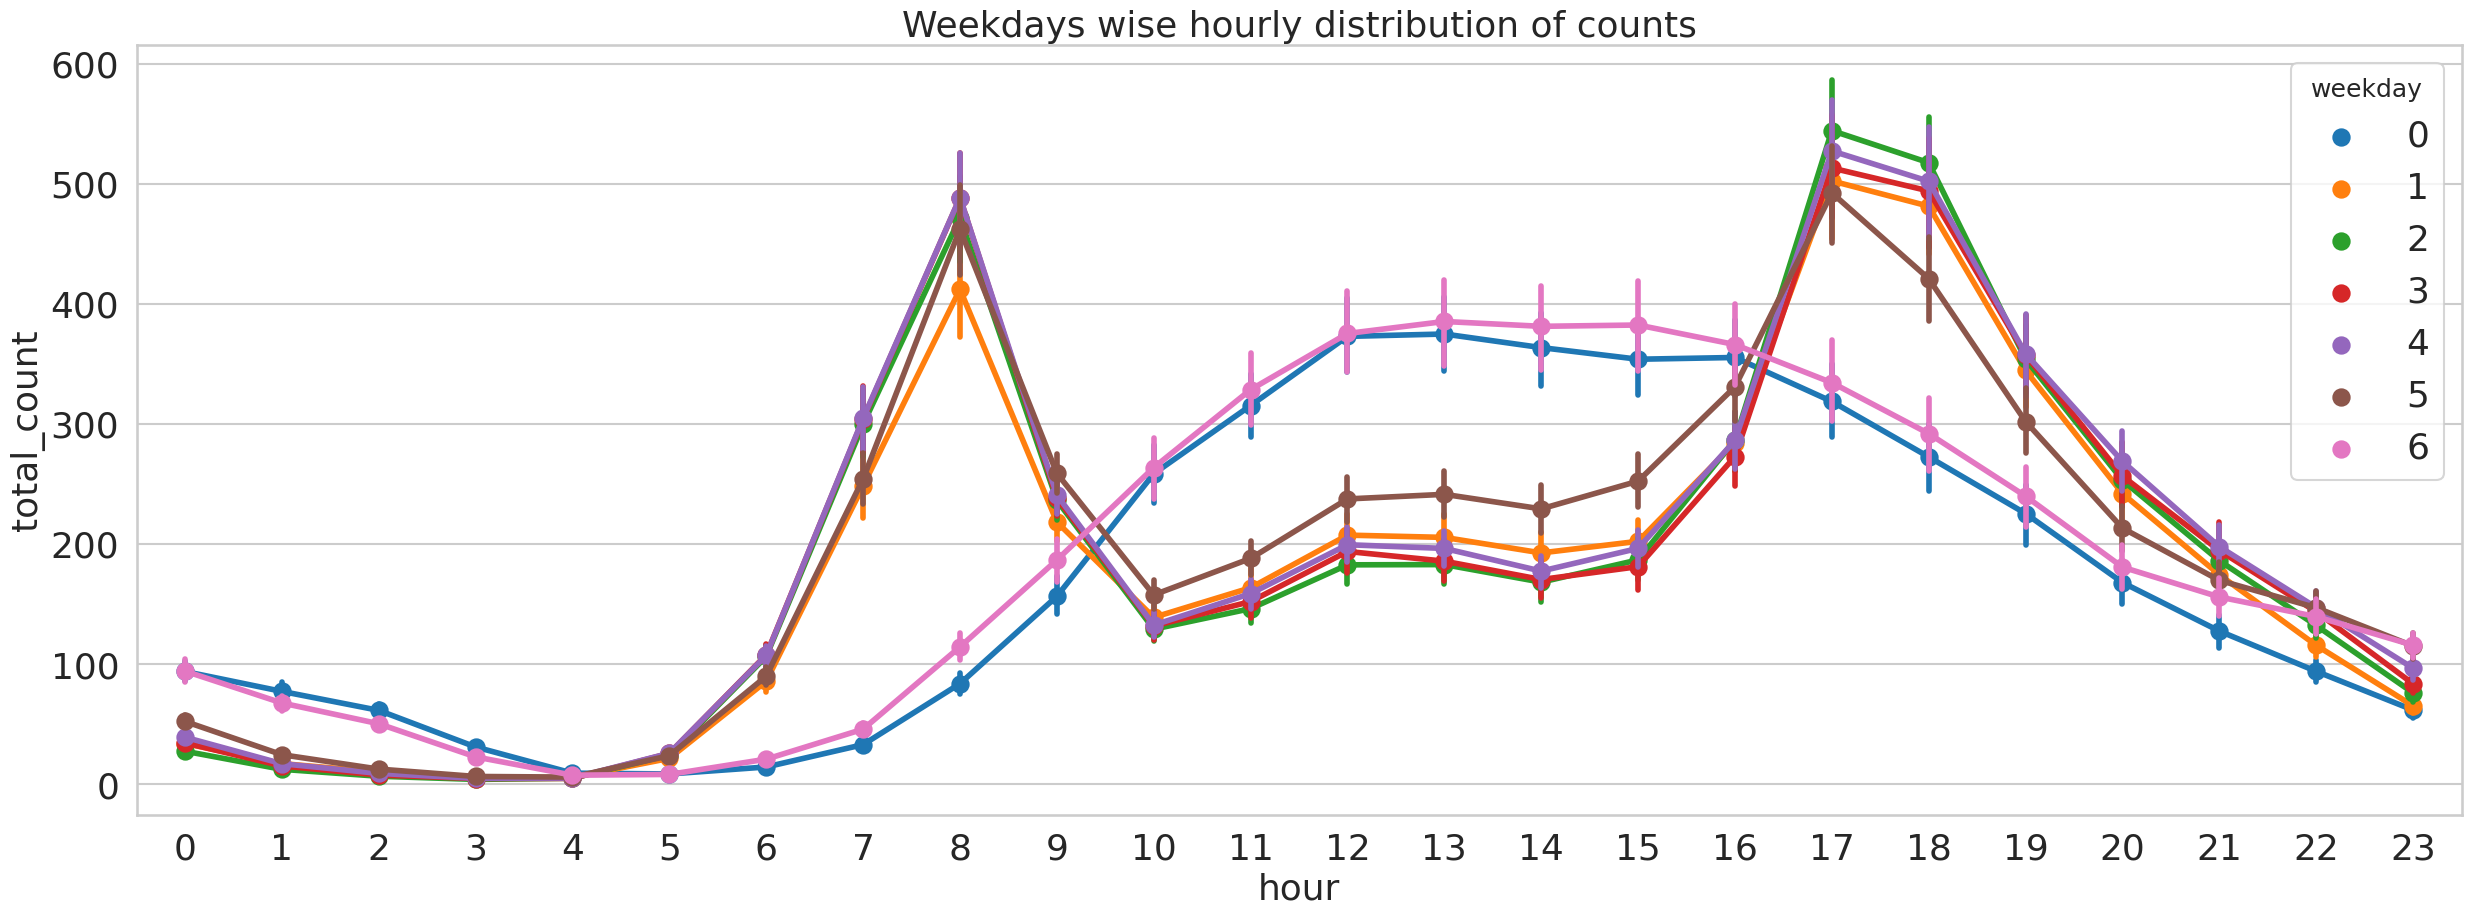

In [7]:
fig, ax = plt.subplots()
sn.pointplot(data= hour_df[['total_count', 'hour', 'weekday']], x='hour', y='total_count', hue='weekday', ax=ax)
ax.set(title="Weekdays wise hourly distribution of counts")

Similarly, distribution of ridership across days of the week also presents interesting trends of higher usage during afternoon hours over weekends, while weekdays see higher usage during mornings and evenings.

Having observed hourly distribution of data across different categoricals, let’s see if there are any aggregated trends.

[Text(0.5, 1.0, 'Monthly distribution of counts')]

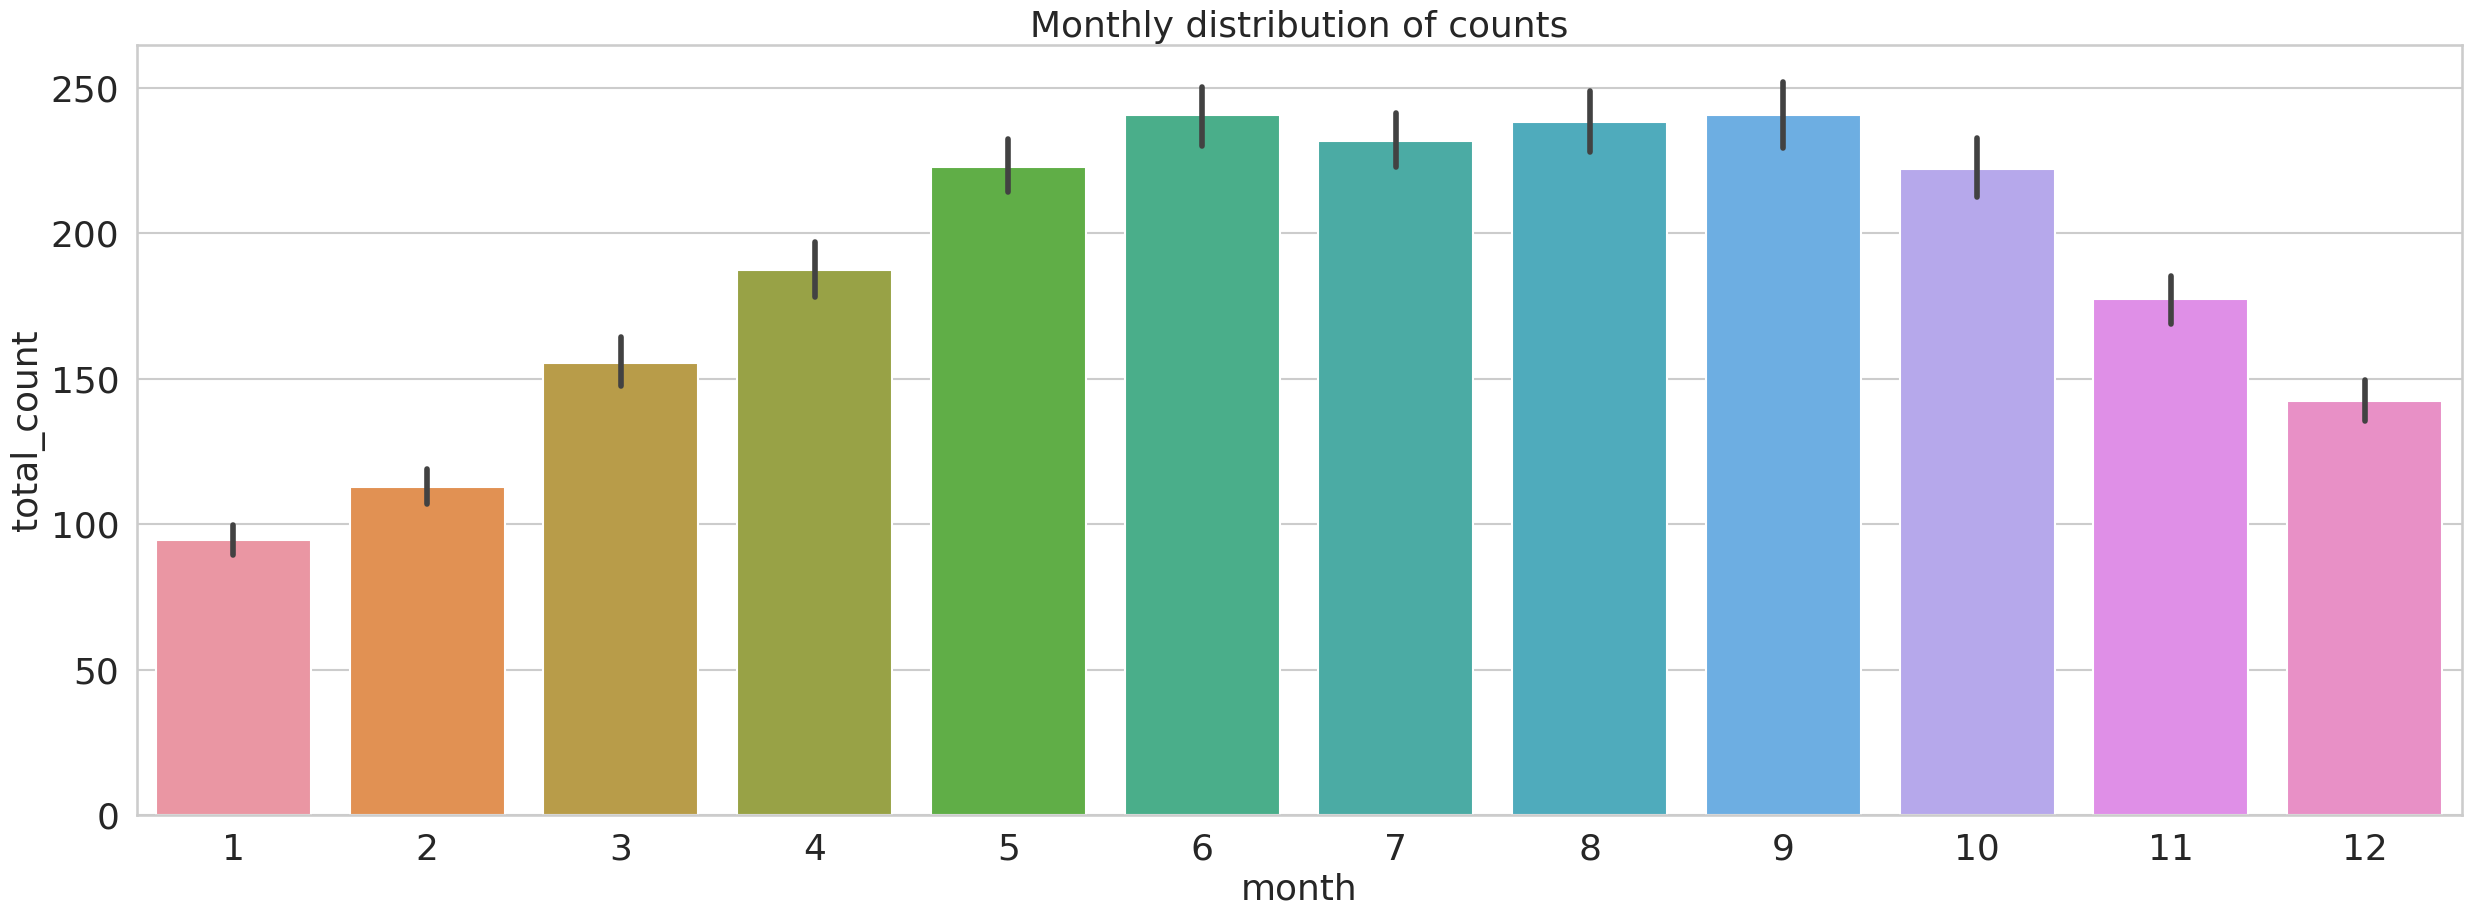

In [8]:
fig, ax = plt.subplots()
sn.barplot(data = hour_df[['month', 'total_count']], x='month', y='total_count')
ax.set(title="Monthly distribution of counts")

Moving up the aggregation level, let’s look at the distribution at year level. Our dataset contains year value of 0 representing 2011 and 1 representing 2012. We use a violin plot to understand multiple facets of this distribution in a crisp format.

<AxesSubplot:xlabel='year', ylabel='total_count'>

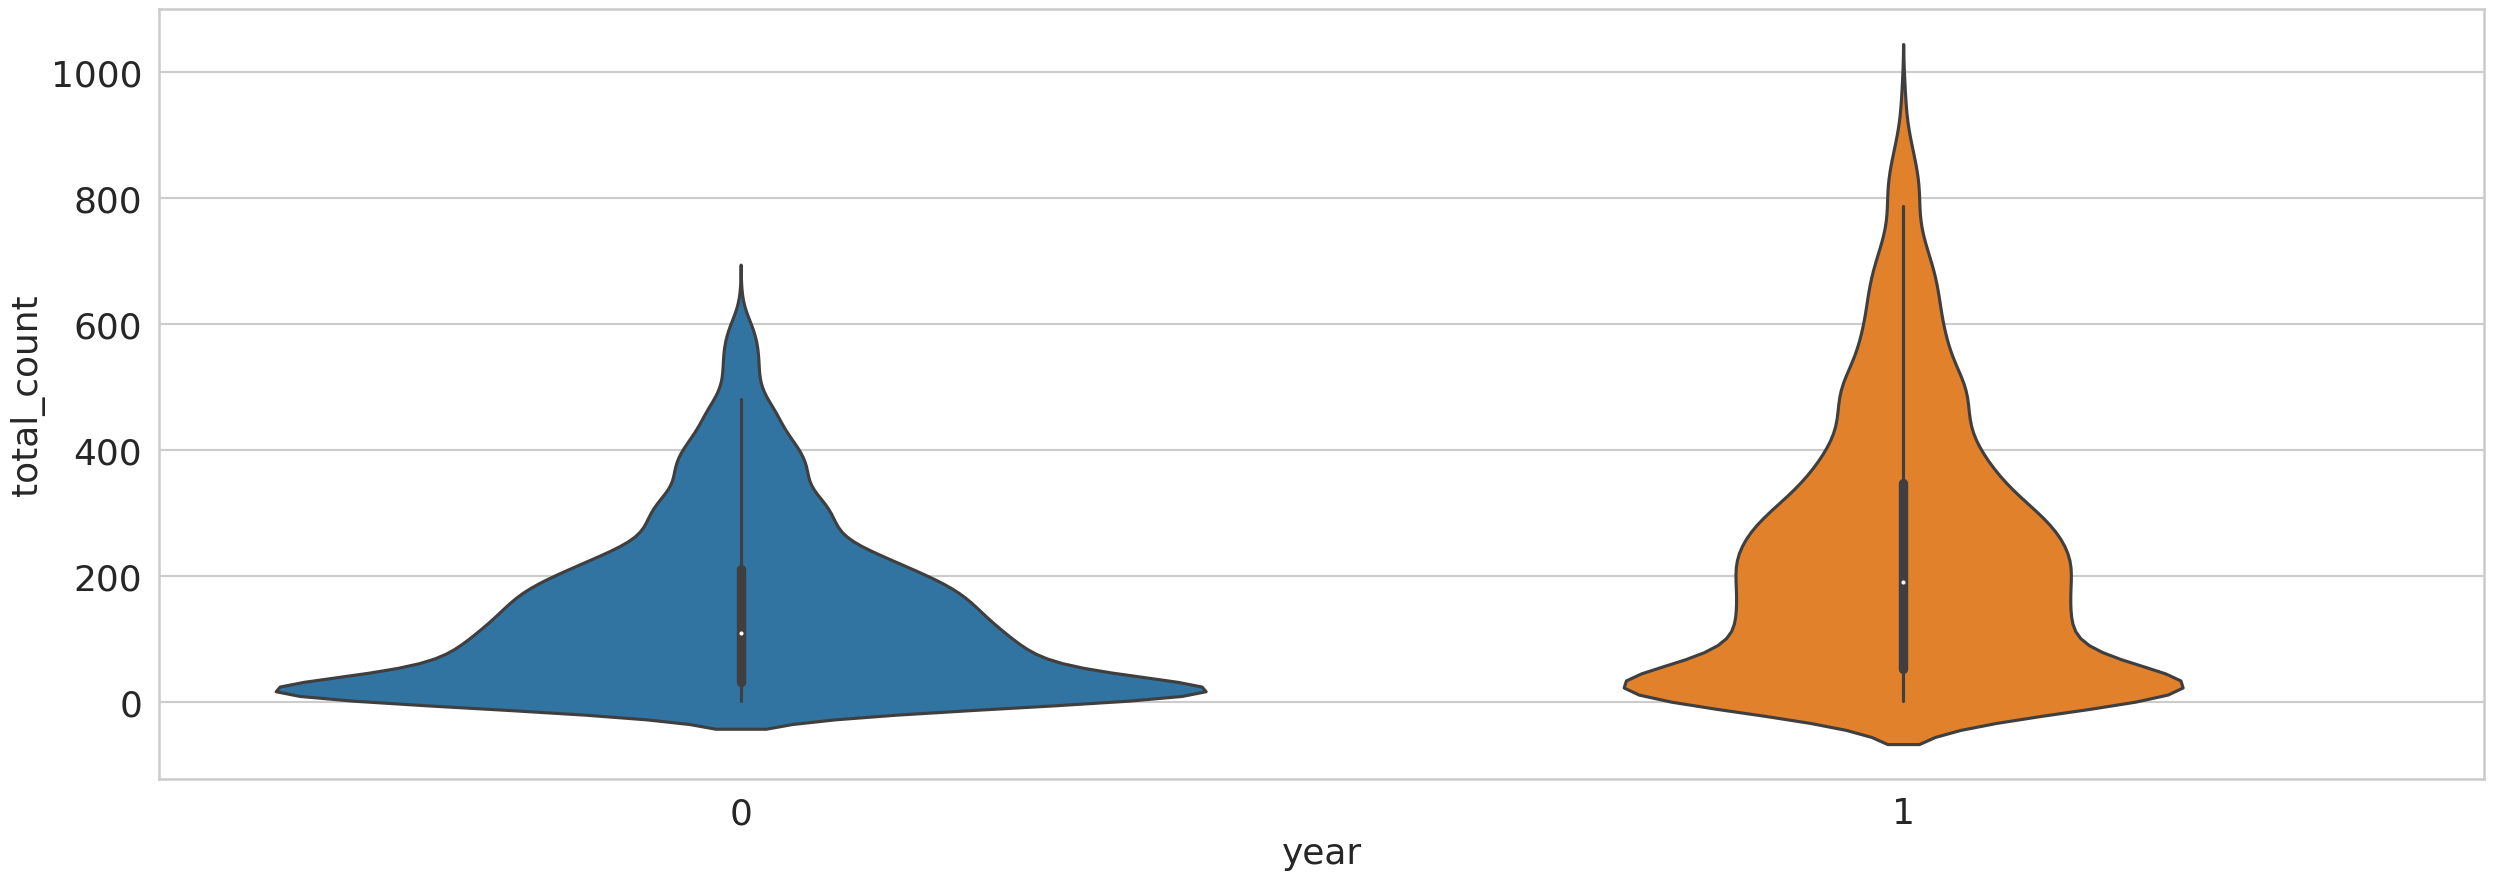

In [9]:
sn.violinplot(data=hour_df[['year', 'total_count']], x='year', y='total_count')

Figure above clearly helps us understand the multimodal distribution in both 2011 and 2012 ridership counts with 2011 having peaks at lowervalues as compared to 2012. The spread of counts is also much more for 2012, although the max density for both the years is between 100-200 rides.

<u><b>Outliers</b></u>

While exploring and learning about any dataset , it is imperative that we
check for extreme and unlikely values. Though we handle missing and
incorrect information while preprocessing the dataset, outliers are usually
caught during EDA. Outliers can severely and adversely impact the
downstream steps like modeling and the results.

We usually utilize boxplots to check for outliers in the data. In the following snippet, we analyze outliers for numeric attributes like total_count, temperature, and wind_speed.

<AxesSubplot:>

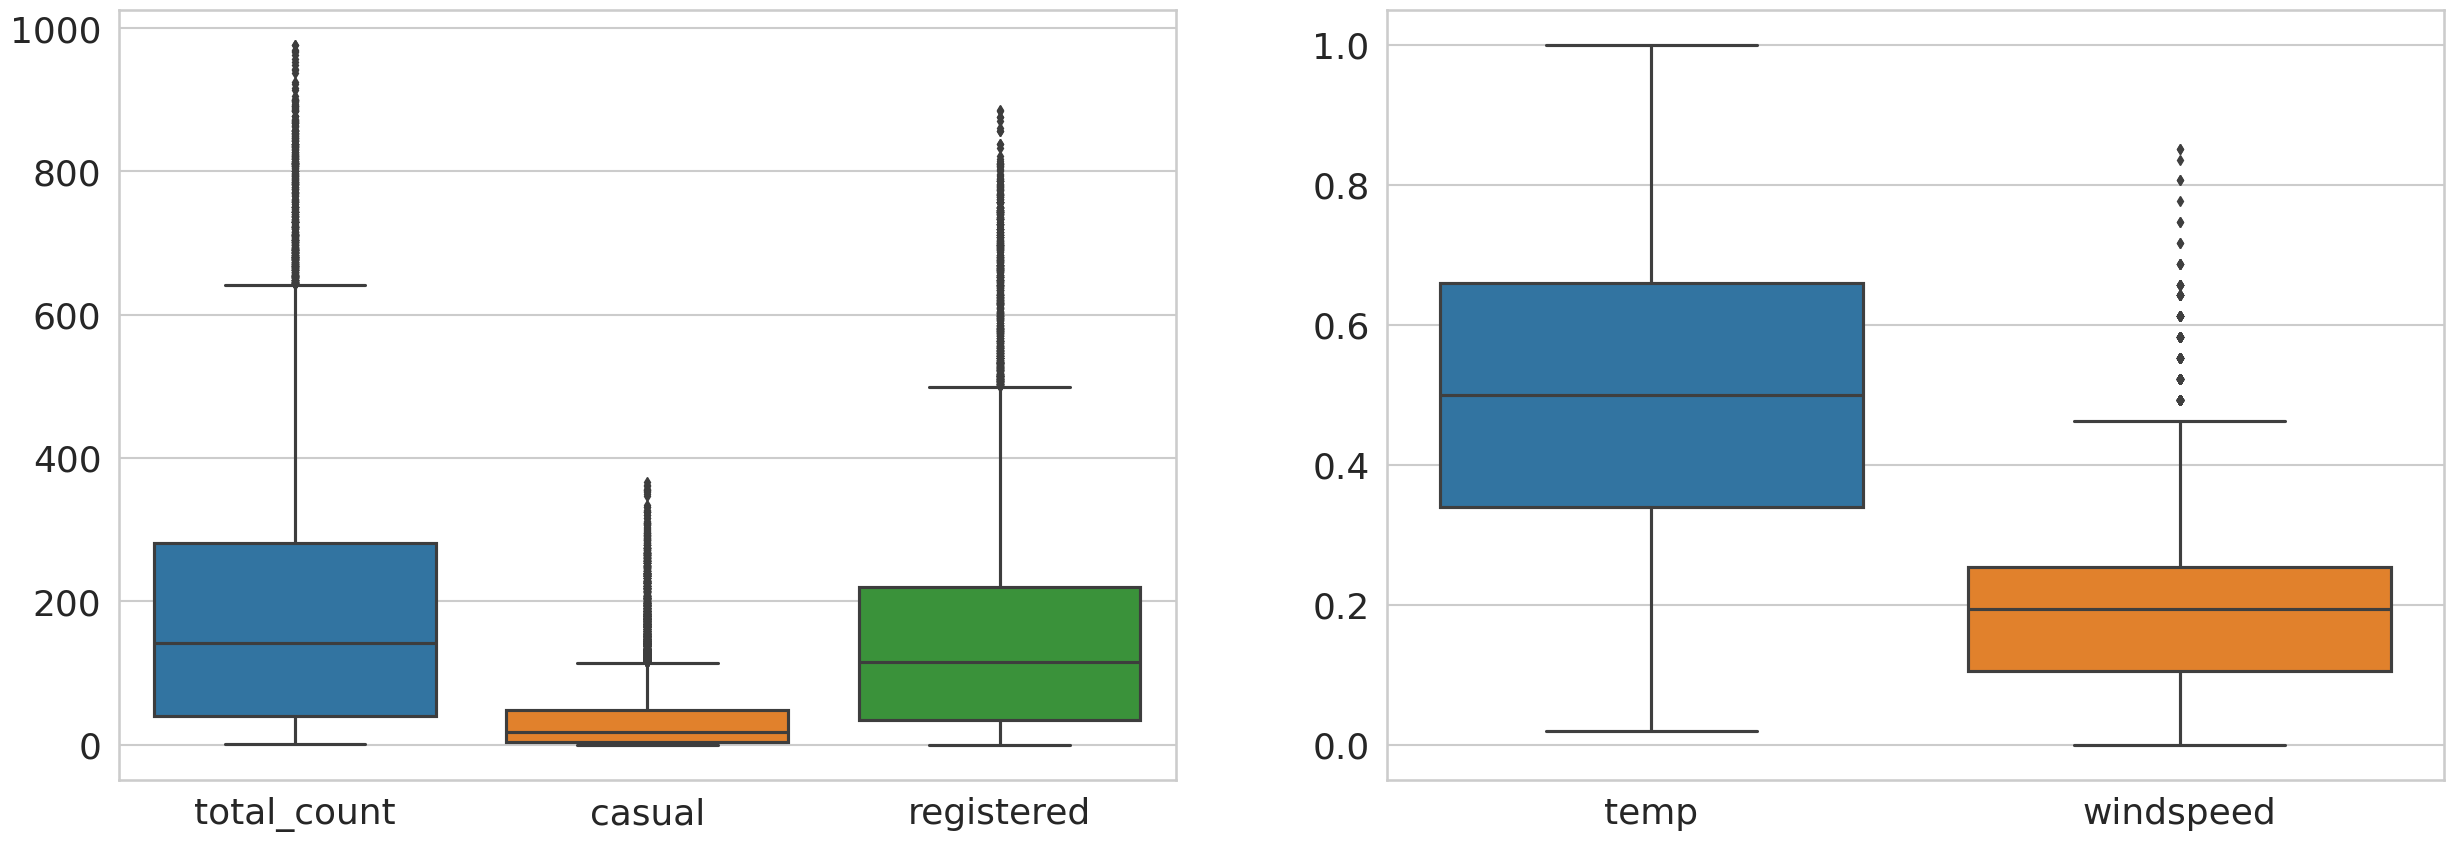

In [10]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
sn.boxplot(data=hour_df[['total_count', 'casual', 'registered']], ax=ax1)
sn.boxplot(data=hour_df[['temp', 'windspeed']], ax=ax2)

The generated plot is shown in Figure above. We can easily mark out that for the three count related attributes, all of them seem to have a sizable number of outlier values. The casual rider distribution has overall lower numbers though. For weather attributes of temperature and wind speed, we find outliers only in the case of wind speed.

<AxesSubplot:xlabel='hour', ylabel='total_count'>

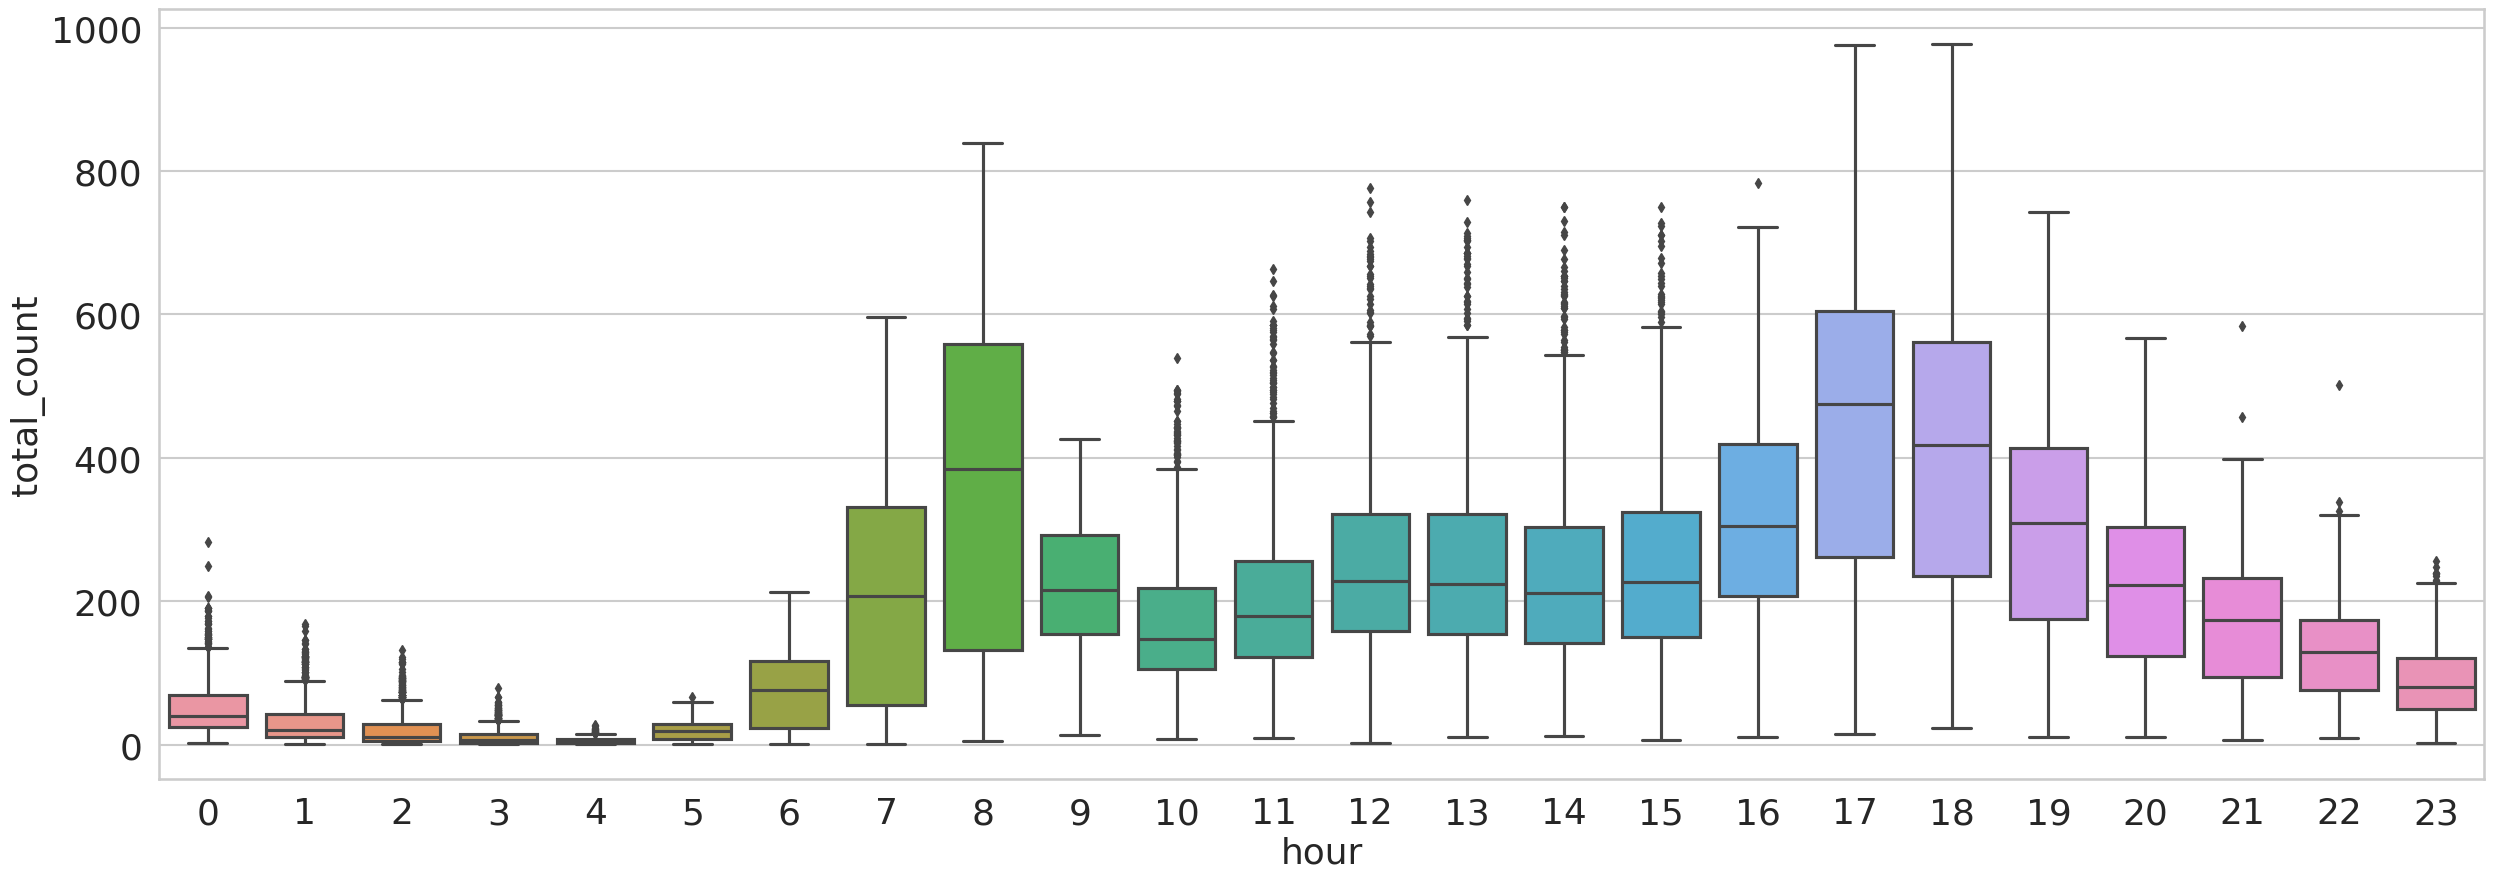

In [11]:
fig, ax3 = plt.subplots()
sn.boxplot(data=hour_df[['hour', 'total_count']],x='hour', y='total_count' ,ax=ax3)

We can similarly try to check outliers at different granularity levels like hourly, monthly, and so on. The visualization in Figure above showcases boxplots at hourly level, <b>*The above graph is extra one</b>

<b><u>Correlations</b></u>


Correlation helps us understand relationships between different attributes of the data. Since this chapter focuses on forecasting, correlations can help us understand and exploit relationships to build better models.

The following snippet first prepares a correlational matrix using the
pandas utility function corr(). It then uses a heat map to plot the
correlation matrix.

<AxesSubplot:>

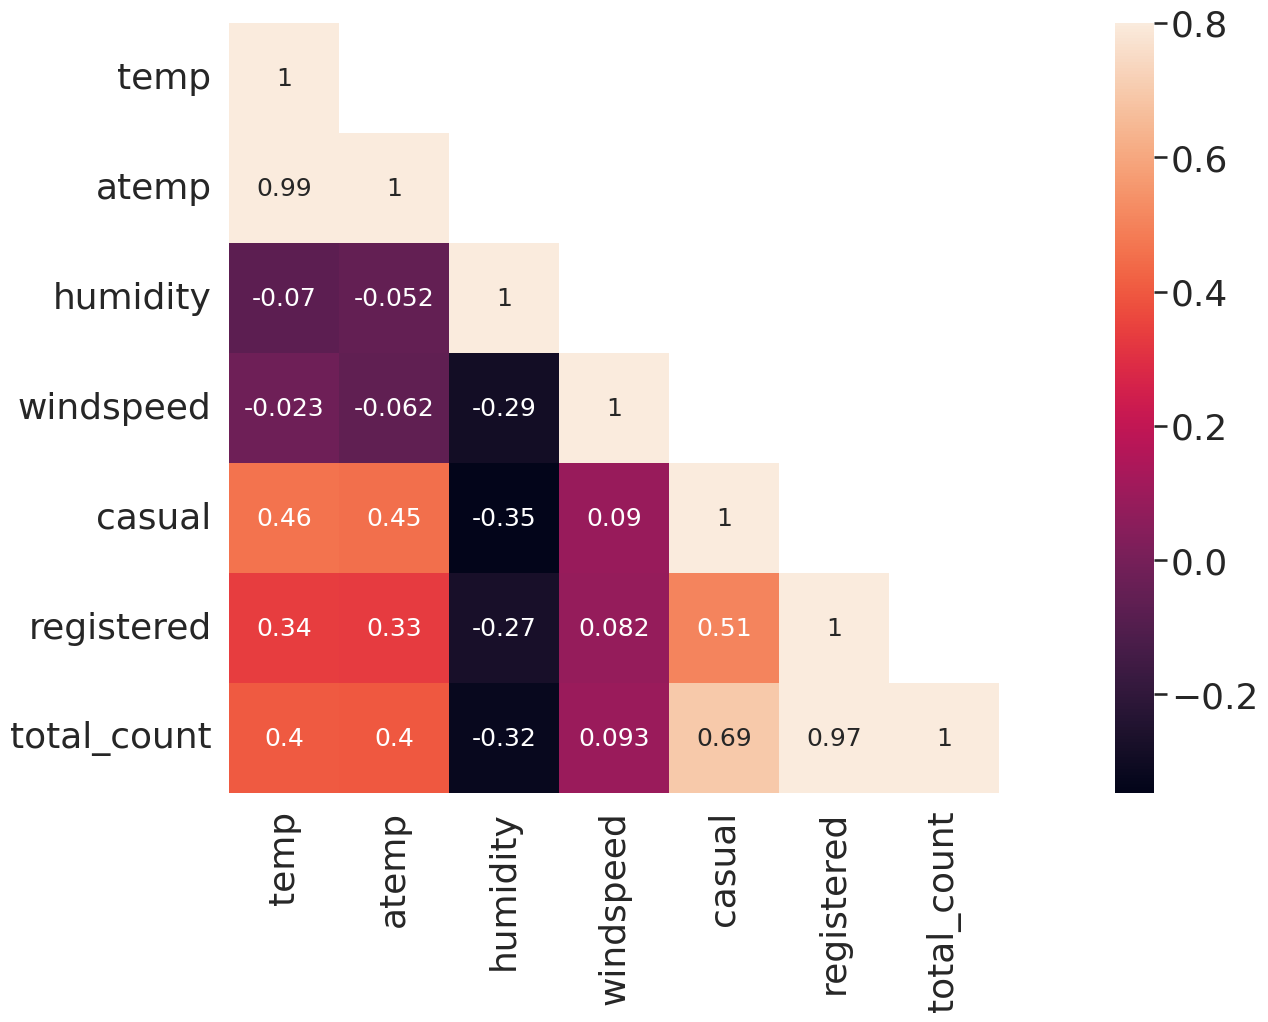

In [12]:
corrMatrix = hour_df[['temp', 'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'total_count']].corr()
mask = np.array(corrMatrix)
mask[np.tril_indices_from(mask)] = False
sn.heatmap(corrMatrix, mask=mask, vmax=.8, square=True, annot=True)

Figure above shows the output correlational matrix (heat map) showing values in the lower triangular form on a blue to red gradient (negative to positive correlation).

The two count variables, registered and casual, show obvious strong correlation to total_count. Similarly, temp and atemp show high correlation. wind_speed and humidity have slight negative correlation. Overall, none of the attributes show high correlational statistics.

<u><b>Regression Analysis</b></u>

Regression analysis is a statistical modeling technique used by statisticians and Data Scientists alike. It is the process of investigating relationships between dependent and independent variables. Regression itself includes a variety of techniques for modeling and analyzing relationships between variables. It is widely used for predictive analysis, forecasting, and time series analysis.

The dependent or target variable is estimated as a function of independent or predictor variables. The estimation function is called the regression function.

In [13]:
def fit_transform_ohe(df,col_name):
    """This function performs one hot encoding for the specified column.
    Args: df(pandas.DataFrame): the data frame containing the mentioned column name
    col_name: the column to be one hot encoded
    Returns: tuple: label_encoder, one_hot_encoder, transformed column as pandas Series """

    # label encode the column
    le = preprocessing.LabelEncoder()
    le_labels = le.fit_transform(df[col_name])
    df[col_name+'_label'] = le_labels

    # one hot encoding
    ohe = preprocessing.OneHotEncoder()
    feature_arr = ohe.fit_transform(df[[col_name+'_label']]).toarray()
    feature_labels = [col_name+'_'+str(cls_label) for cls_label in le.classes_]
    features_df = pd.DataFrame(feature_arr, columns=feature_labels)
    return le,ohe,features_df

def transform_ohe(df,le,ohe,col_name):
    """This function performs one hot encoding for the specified
        column using the specified encoder objects.

    Args:
        df(pandas.DataFrame): the data frame containing the mentioned column name
        le(Label Encoder): the label encoder object used to fit label encoding
        ohe(One Hot Encoder): the onen hot encoder object used to fit one hot encoding
        col_name: the column to be one hot encoded

    Returns:
        tuple: transformed column as pandas Series

    """
    # label encode
    col_labels = le.transform(df[col_name])
    df[col_name+'_label'] = col_labels
    
    # ohe 
    feature_arr = ohe.fit_transform(df[[col_name+'_label']]).toarray()
    feature_labels = [col_name+'_'+str(cls_label) for cls_label in le.classes_]
    features_df = pd.DataFrame(feature_arr, columns=feature_labels)
    
    return features_df

<b>Here, The terminology used is:</b>
    </br>1. One-hot encoding is used in machine learning as a method to quantify categorical data. In short, this method produces a vector with length equal to the number of categories in the data set.
    </br>Example: [0,1,0,0] // female,  [1,0,0,0] // male, [0,0,1,0] // gender-neutral
    </br>2. Label Encoding refers to converting the labels into a numeric form so as to convert them into the machine-readable form. Machine learning algorithms can then decide in a better way how those labels must be operated. It is an important pre-processing step for the structured dataset in supervised learning.</br>
-->We use the fit_transform_ohe() function along with transform_ohe() to encode the categoricals. The Label and One Hot
encoders are available as part of scikit-learn’s preprocessing module.</br>
-->Both scikit-leran and sklearn are same, The only difference is that the one is the dummy package of the other, But they do the same thing only.</br>

<b><b>Train-Test Split</b></b>

In [14]:
x, x_test, y, y_test = train_test_split(hour_df.iloc[:,0:-3], hour_df.iloc[:, -1], test_size=0.33, random_state=42)
x.reset_index(inplace=True)
y = y.reset_index()

x_test.reset_index(inplace=True)
y_test = y_test.reset_index()

print("Training set::{}{}".format(x.shape,y.shape))
print("Testing set::{}".format(x_test.shape))

Training set::(11643, 15)(11643, 2)
Testing set::(5736, 15)


In [15]:
# The following snippent loops through the list of categorigical variables to transform and prepare a list of encoded attributes
cat_attr_list = ['season','is_holiday', 'weather_condition','is_workingday', 'hour','weekday','month','year']
numeric_feature_cols = ['temp','humidity','windspeed','hour','weekday','month','year']
subset_cat_features =  ['season','is_holiday','weather_condition','is_workingday']

encoded_attr_list = []
for col in cat_attr_list:
    return_obj = fit_transform_ohe(x, col)
    encoded_attr_list.append({'label_enc': return_obj[0],
                             'ohe_enc': return_obj[1],
                             'feature_df': return_obj[2],
                             'col_name': col})

Next, we merge the numeric and one hot encoded categoricals into a dataframe that we will use for our modeling purposes. The following snippet helps us prepare the required dataset.

Next, we merge the numeric and one hot encoded categoricals into a dataframe that we will use for our modeling purposes. The following snippet helps us prepare the required dataset.

Note Though we have transformed all categoricals into their one-hot encodings, note that ordinal attributes such as hour, weekday, and so on do not require such encoding.

In [16]:
feature_df_list = [x[numeric_feature_cols]]
feature_df_list.extend([enc['feature_df'] for enc in encoded_attr_list if enc['col_name'] in subset_cat_features])
train_df_new = pd.concat(feature_df_list, axis=1)
print("Shape :: {}".format(train_df_new.shape))

Shape :: (11643, 19)


We prepared a new dataframe using numeric and one hot encoded categorical attributes from the original training dataframe. The original dataframe had 10 such attributes (including both numeric and categoricals). Post this transformation, the new dataframe has 19 attributes due to one hot encoding of the categoricals.

<b><b><u>Decession Tree based Regression</u></b></b>
<b><b>Sample Decision Tree Regressor</b></b>

In [17]:
x = train_df_new
y = y.total_count.values.reshape(-1, 1)

x.shape, y.shape

((11643, 19), (11643, 1))

In [18]:
dtr = DecisionTreeRegressor(max_depth=4, min_samples_split=5, max_leaf_nodes=10)
dtr.fit(x, y)

DecisionTreeRegressor(max_depth=4, max_leaf_nodes=10, min_samples_split=5)

In [19]:
dtr.score(x, y)

0.5645919317952333

In [20]:
# PLot the Learnt Model
dot_data = tree.export_graphviz(dtr, out_file=None)
graph = pydotplus.graph_from_dot_data(dot_data)
graph.write_pdf("bikeshare.pdf")

True

<b><b>Grid Search With Cross Validation</b></b>
</br>Now we start with the actual training process. As must be evident from our workflow so far, we would train our regressor using k-fold cross validation . Since we have hyperparameters as well in case of decision trees to worry, we need a method to fine-tune them as well.
</br>There are many ways of fine-tuning the hyperparameters, the most common ones are grid search and random search, with grid search being the more popular one. As the name suggests, random search randomly searches the combinations of hyperparameters to find the best combination, grid search on the other hand is a more systematic approach where all combinations are tried before the best is identified. To make our lives easier, sklearn provides a utility to grid search the hyperparameters while cross validating the model using the GridSearchCV() method from model_selection module.
</br>The GridSearchCV() method takes the Regression/Classifier object as input parameter along with a dictionary of hyperparameters, number of cross validations required, and a few more. We use the following dictionary to define our grid of hyperparameters .

In [21]:
param_grid = {"criterion": ["squared_error", "absolute_error"],
              "min_samples_split": [10, 20, 40],
              "max_depth": [2, 6, 8],
              "min_samples_leaf": [20, 40, 100],
              "max_leaf_nodes": [5, 20, 100, 500, 800],
              }

In [22]:
grid_cv_dtr = GridSearchCV(dtr, param_grid, cv=5)
grid_cv_dtr.fit(x, y)

GridSearchCV(cv=5,
             estimator=DecisionTreeRegressor(max_depth=4, max_leaf_nodes=10,
                                             min_samples_split=5),
             param_grid={'criterion': ['squared_error', 'absolute_error'],
                         'max_depth': [2, 6, 8],
                         'max_leaf_nodes': [5, 20, 100, 500, 800],
                         'min_samples_leaf': [20, 40, 100],
                         'min_samples_split': [10, 20, 40]})

The grid search of hyperparameters with k-fold cross validation is an iterative process wrapped, optimized, and standardized by
GridSearchCV() function . The training process takes time due to the same and results in quite a few useful attributes to analyze. The best_score_ attribute helps us get the best cross validation score our Decision Tree Regressor could achieve. We can view the hyperparameters for the model that generates the best score using best_params_. We can view the detailed information of each iteration of GridSearchCV() using the cv_results_ attribute. The following snippet showcases some of these attributes.

In [24]:
print("R-Squared :: {}".format(grid_cv_dtr.best_score_))
print("Best Hyperparametres :: \n{}".format(grid_cv_dtr.best_params_))

R-Squared :: 0.8333284746008405
Best Hyperparametres :: 
{'criterion': 'squared_error', 'max_depth': 8, 'max_leaf_nodes': 500, 'min_samples_leaf': 20, 'min_samples_split': 10}


In [28]:
df = pd.DataFrame(grid_cv_dtr.cv_results_)
df.head

<bound method NDFrame.head of      mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0         0.007126      0.001049         0.001680        0.000474   
1         0.006642      0.000404         0.001837        0.000560   
2         0.006354      0.000282         0.001539        0.000312   
3         0.006385      0.000364         0.001583        0.000277   
4         0.006220      0.000401         0.001410        0.000077   
..             ...           ...              ...             ...   
265       1.599326      0.011054         0.001386        0.000024   
266       1.596294      0.011383         0.001384        0.000040   
267       1.553239      0.009479         0.001360        0.000035   
268       1.552333      0.007772         0.001372        0.000035   
269       1.550065      0.009602         0.001371        0.000031   

    param_criterion param_max_depth param_max_leaf_nodes  \
0     squared_error               2                    5   
1     squared_error  

It important to understand that grid search with cross validation was optimizing on finding the best set of hyperparameters that can help prepare a generalizable Decision Tree Regressor . It may be possible that there are further optimizations possible. We use seaborn to plot the impact of depth of the tree on the overall score along with number of leaf nodes.

[Text(0.5, 1.0, 'Affect of depth and leaf Nodes on Model Performance')]

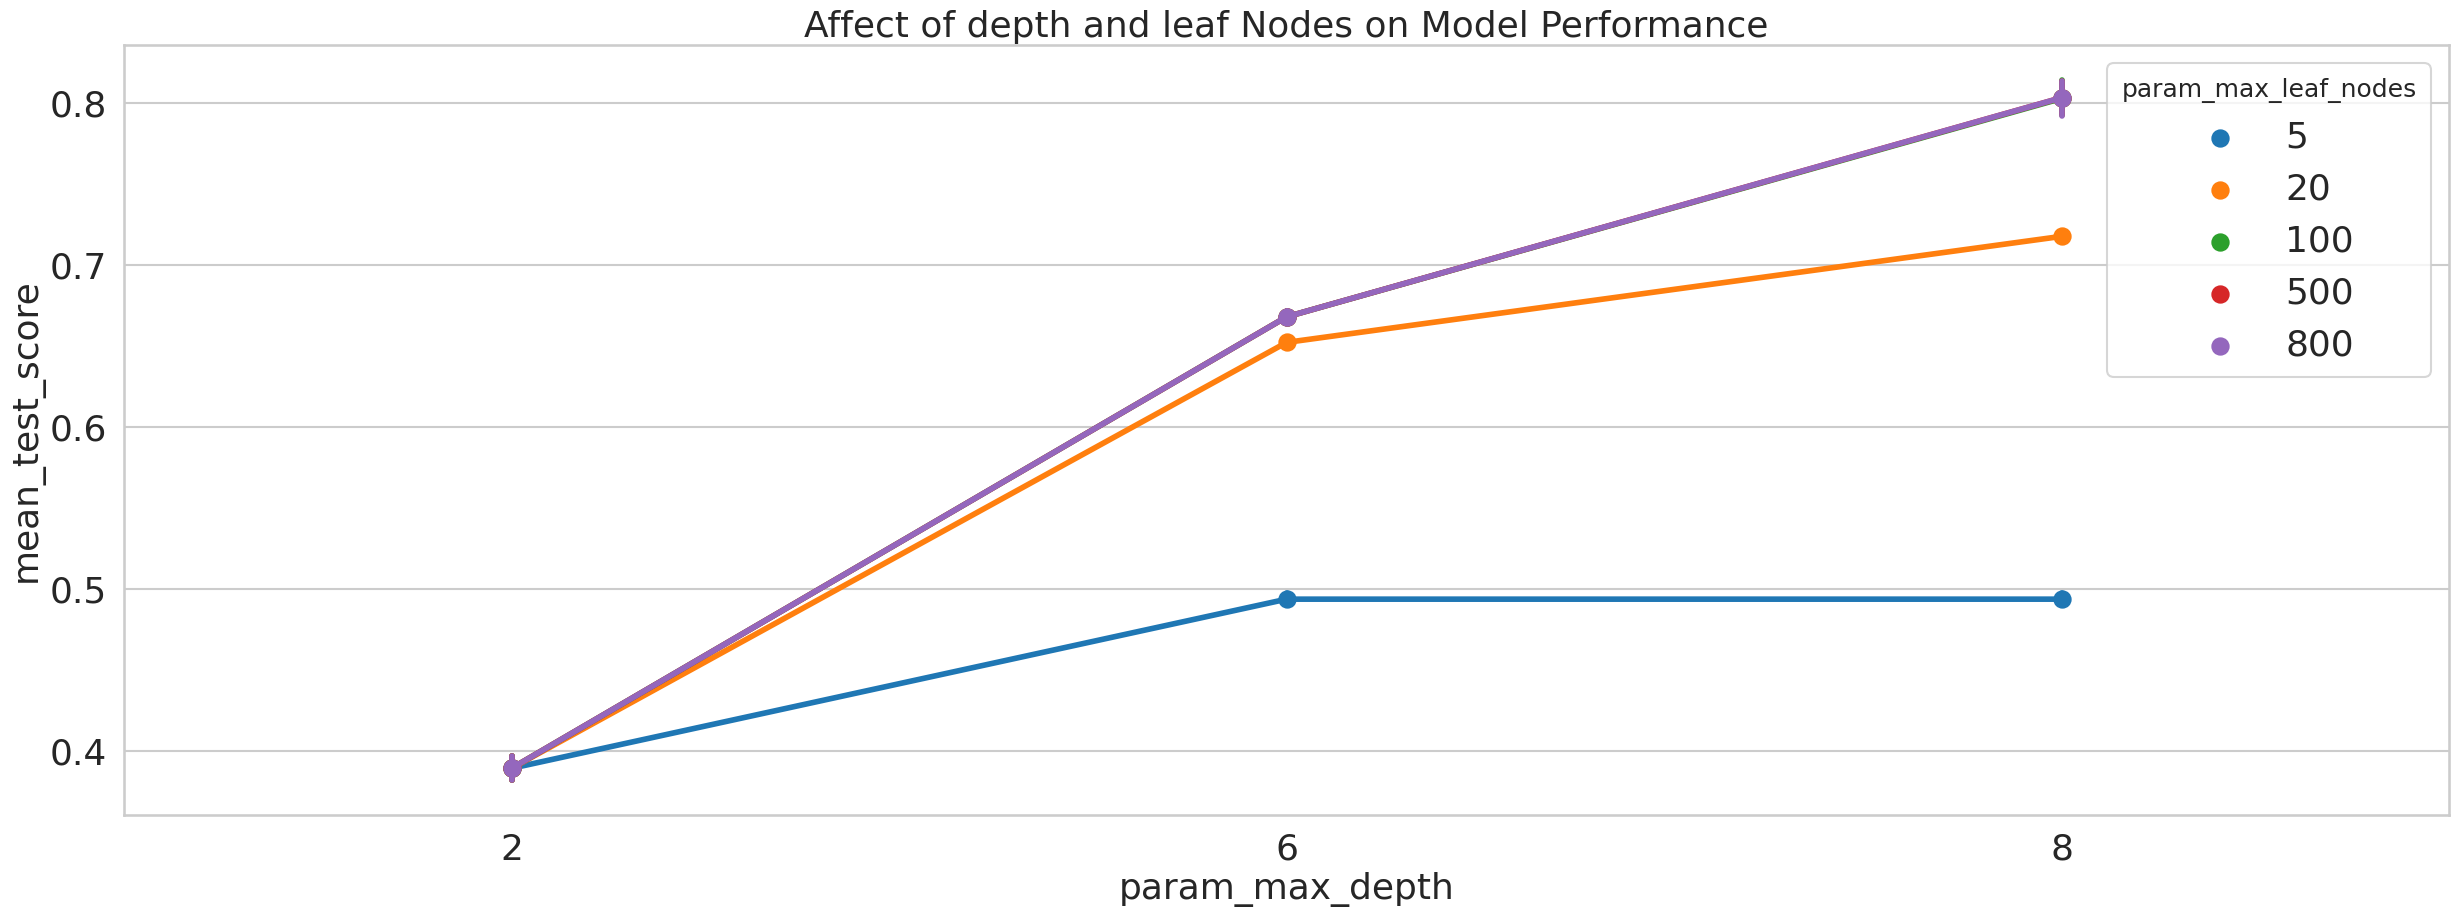

In [29]:
fig, ax = plt.subplots()
sn.pointplot(data = df[['mean_test_score', 'param_max_leaf_nodes', 'param_max_depth']], y='mean_test_score', x='param_max_depth', hue='param_max_leaf_nodes')
ax.set(title="Affect of depth and leaf Nodes on Model Performance")

The output shows a sudden improvement in score as depth increases from 2 to 6 while a gradual improvement as we reach 8 from 6. The impact of number of leaf nodes is rather interesting. The difference in scores between 100 and 800 leaf nodes is strikingly not much. This is a clear indicator that further fine-tuning is possible. Figure above depicts the visualization showcasing these results.
</br>
As mentioned, there is still scope of fine-tuning to further improve the results. It is therefore a decision which is use case and cost dependent. Cost can be in terms of effort, time and corresponding improvements achieved.
For now, we’ll proceed with the best model our GridSearchCV object has helped us identify.

<b><b><u>Residual Plot</u></b></b>
</br>Using residual plots, you can assess whether the observed error (residuals) is consistent with stochastic error. You shouldn't be able to predict the error for any given observation. And, for a series of observations, you can determine whether the residuals are consistent with random error.

In [32]:
predicted = grid_cv_dtr.best_estimator_.predict(x)
residuals = y.flatten()-predicted

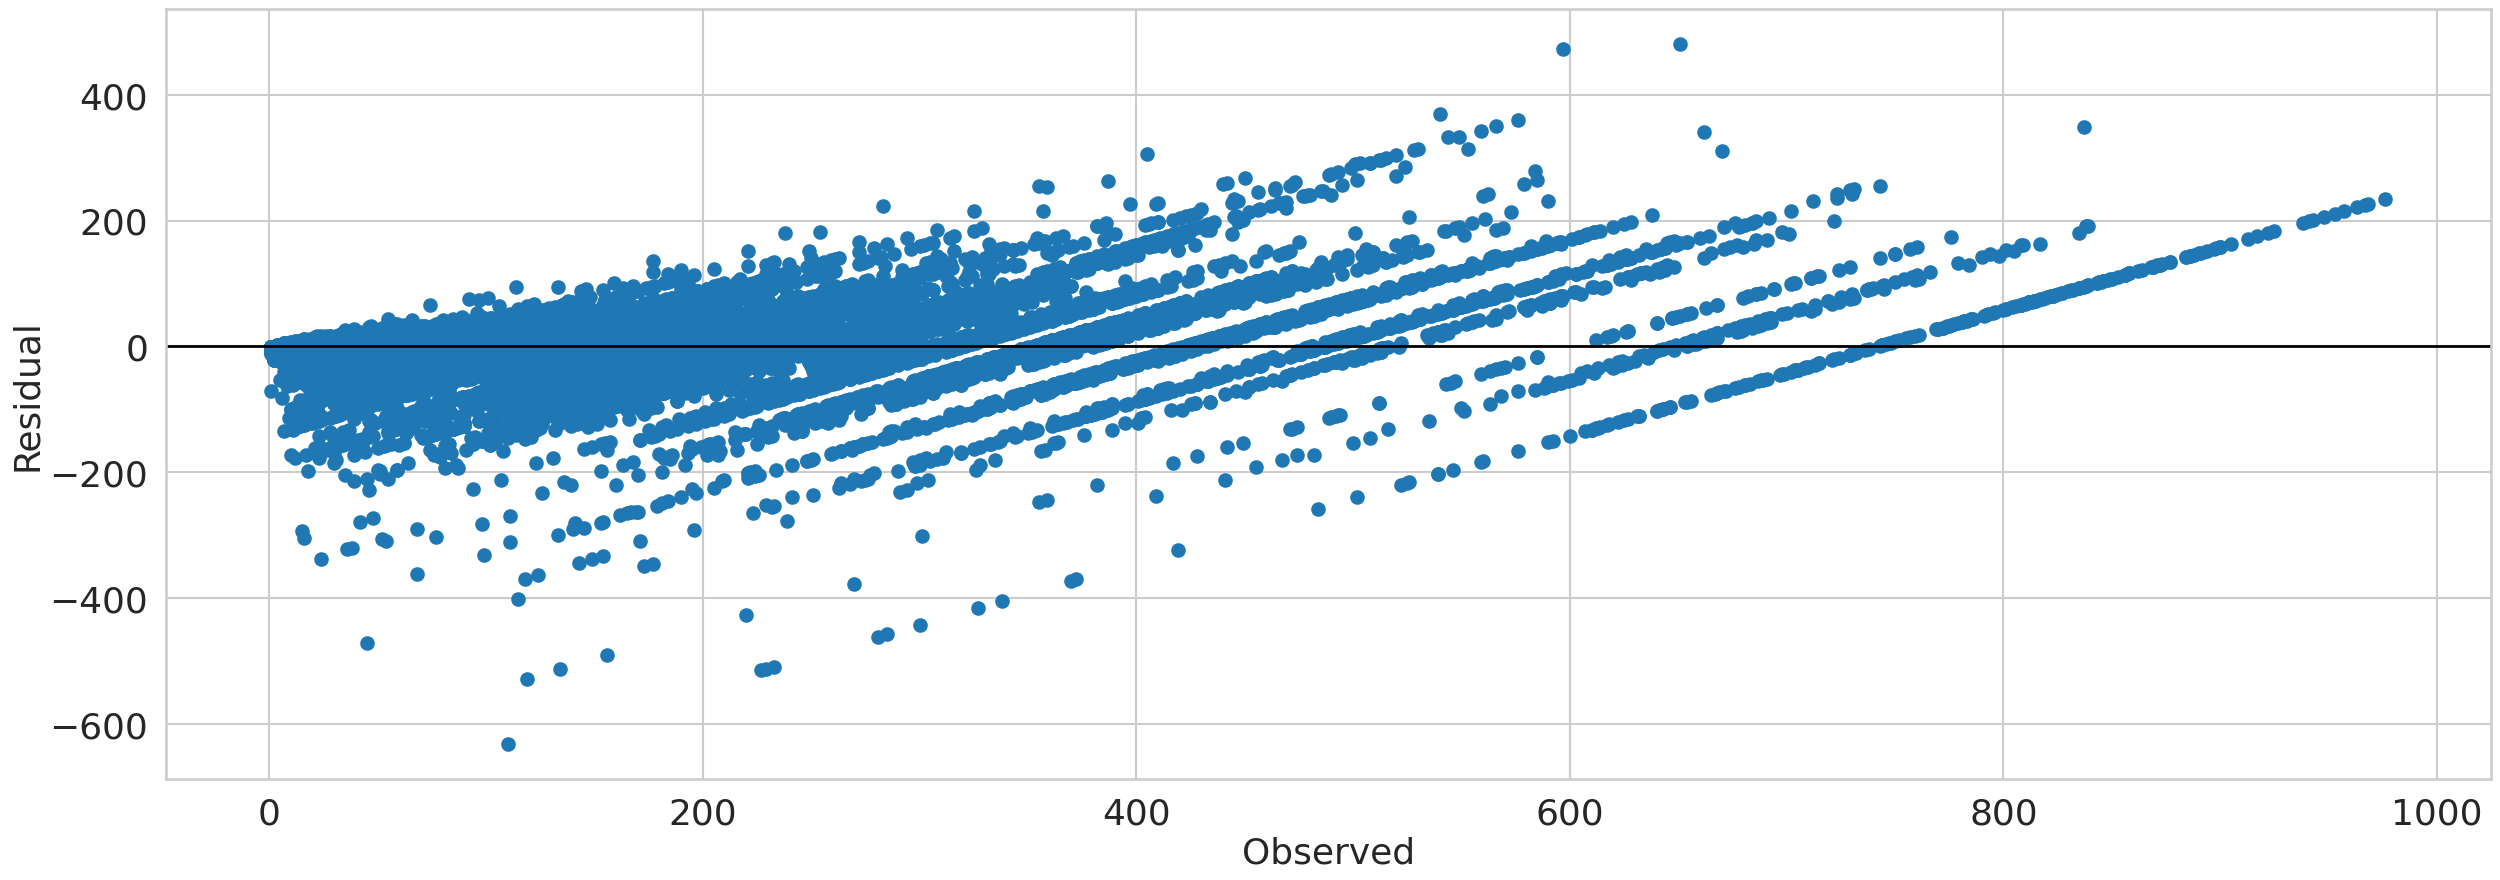

In [33]:
fig, ax = plt.subplots()
ax.scatter(y.flatten(), residuals)
ax.axhline(lw=2, color='black')
ax.set_xlabel('Observed')
ax.set_ylabel('Residual')
plt.show()

In [35]:
r2_score = cross_val_score(grid_cv_dtr.best_estimator_, x, y, cv=10)
mse_score = cross_val_score(grid_cv_dtr.best_estimator_, x, y, cv=10, scoring='neg_mean_squared_error')

In [37]:
print("Avg R-Squared :: {}".format(np.mean(r2_score)))
print("MSE :: {}".format(np.mean(mse_score)))

Avg R-Squared :: 0.8375948069484194
MSE :: -5406.524080066271


<b><b><u>Important</u></b></b>
</br>Using residual plots, you can assess whether the observed error (residuals) is consistent with stochastic error. You shouldn't be able to predict the error for any given observation. And, for a series of observations, you can determine whether the residuals are consistent with random error.

<b><b><u>Testing</u></b></b>

In [42]:
best_dtr_model = grid_cv_dtr.best_estimator_

test_encoded_attr_list = []
for enc in encoded_attr_list:
    col_name = enc['col_name']
    le = enc['label_enc']
    ohe = enc['ohe_enc']
    test_encoded_attr_list.append({'feature_df':transform_ohe(x_test,le,ohe,col_name), 'col_name':col_name})
    
test_feature_df_list = [x_test[numeric_feature_cols]]
test_feature_df_list.extend([enc['feature_df'] for enc in test_encoded_attr_list if enc['col_name'] in subset_cat_features])

test_df_new = pd.concat(test_feature_df_list, axis=1) 
print("Shape::{}".format(test_df_new.shape))

Shape::(5736, 19)


In [43]:
x_test = test_df_new
y_test = y_test.total_count.values.reshape(-1, 1)

y_pred = best_dtr_model.predict(x_test)
residuals = y_test.flatten() - y_pred

r2_score = best_dtr_model.score(x_test, y_test)
print("R-Squared :: {}".format(r2_score))
print("MSE : %.2f" % metrics.mean_squared_error(y_test, y_pred))

R-Squared :: 0.8478415542500741
MSE : 4854.08


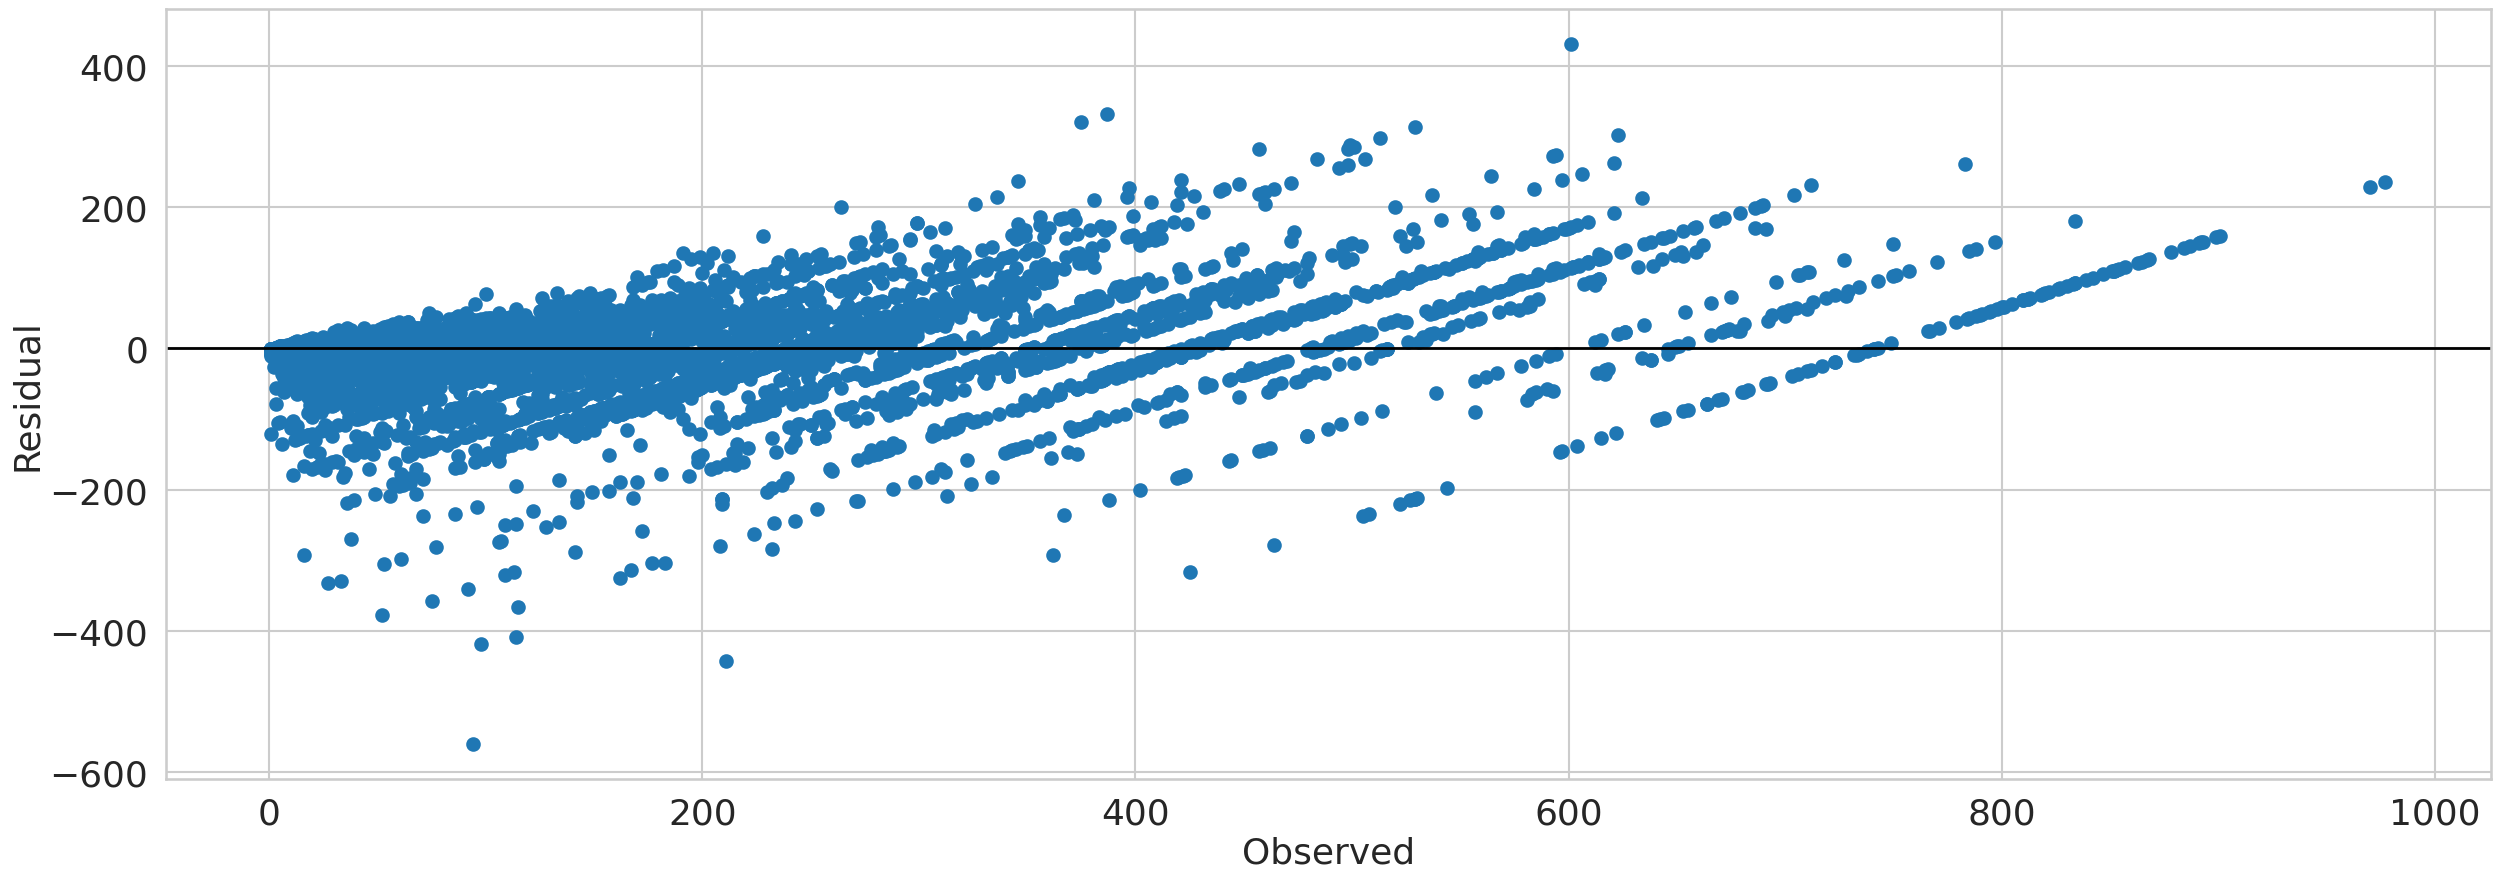

In [44]:
fig, ax = plt.subplots()
ax.scatter(y_test.flatten(), residuals)
ax.axhline(lw=2, color='black')
ax.set_xlabel('Observed')
ax.set_ylabel('Residual')
plt.show()

r2_score = grid_cv_dtr.best_estimator_.score(x_test, y_test)